## SETUP INICIAL - Instalar librerias y configurar Google Colab

In [1]:
# Instalar librerias necesarias
!pip install -q scikit-learn pandas numpy matplotlib seaborn

In [2]:
# Importar librerias
import pandas as pd
import numpy as np
import os
import pickle
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

warnings.filterwarnings('ignore')

# Configurar visualizaciones
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("[OK] Librerias importadas exitosamente")

[OK] Librerias importadas exitosamente


In [3]:
# Configurar Google Colab (si aplica)
try:
    from google.colab import files
    import shutil
    print("[OK] Google Colab configurado")
except:
    print("[INFO] Ejecutando localmente (no es Google Colab)")

print("\nINSTRUCCIONES PARA COLAB:")
print("1. Si tienes el archivo CSV localmente, ejecuta: files.upload()")
print("2. O copia el CSV a tu Google Drive y usa:")
print("   from google.colab import drive")
print("   drive.mount('/content/drive')")
print("3. Luego actualiza dataset_path a la ubicacion correcta")

[OK] Google Colab configurado

INSTRUCCIONES PARA COLAB:
1. Si tienes el archivo CSV localmente, ejecuta: files.upload()
2. O copia el CSV a tu Google Drive y usa:
   from google.colab import drive
   drive.mount('/content/drive')
3. Luego actualiza dataset_path a la ubicacion correcta


---
# FASE 1: SAMPLE - Cargar datos vulnerables
### Objetivo: Cargar 4,656 muestras de codigo vulnerable

In [5]:
print("\n" + "="*80)
print("FASE 1: SAMPLE - Cargar Dataset")
print("="*80)
print("Objetivo: Cargar 4,656 muestras SOLO vulnerables (filtradas de Modelo 1)")

dataset_path = '/content/cybernative_detector_training.csv'

print(f"\nCargando dataset desde: {dataset_path}")

try:
    df = pd.read_csv(dataset_path)
    print(f"[OK] Dataset cargado exitosamente")
except FileNotFoundError:
    print(f"[ERROR] Archivo no encontrado: {dataset_path}")
    df = None

# Filtrar solo muestras vulnerables
df_vuln = df[df['vulnerable'] == 1].copy()

print(f"\nTotal registros cargados: {len(df):,}")
print(f"Registros vulnerables seleccionados: {len(df_vuln):,}")


FASE 1: SAMPLE - Cargar Dataset
Objetivo: Cargar 4,656 muestras SOLO vulnerables (filtradas de Modelo 1)

Cargando dataset desde: /content/cybernative_detector_training.csv
[OK] Dataset cargado exitosamente

Total registros cargados: 9,312
Registros vulnerables seleccionados: 4,656


In [6]:
# Analizar tipos CWE
print(f"\nTipos de vulnerabilidad (CWE):")
print(f"  - Tipos originales en dataset: {df_vuln['tipo_vulnerabilidad'].nunique()}")
print(f"  - Necesitamos consolidarlos a 10 categorias principales")

print("\n[OK] FASE 1 COMPLETADA")


Tipos de vulnerabilidad (CWE):
  - Tipos originales en dataset: 4388
  - Necesitamos consolidarlos a 10 categorias principales

[OK] FASE 1 COMPLETADA


---
# FASE 2: EXPLORE - Explorar y consolidar tipos CWE
### Objetivo: Consolidar 937 tipos CWE en 10 categorias principales

In [7]:
print("\n" + "="*80)
print("FASE 2: EXPLORE - Consolidar Tipos CWE")
print("="*80)
print("Objetivo: Normalizar y consolidar categorias de vulnerabilidad")

# Funciones de consolidacion
def normalize_cwe(cwe_text):
    """Consolida CWEs similares bajo categorias principales"""
    cwe = str(cwe_text).lower().strip()

    if 'deserializ' in cwe:
        return 'Insecure Deserialization'
    elif 'buffer' in cwe or 'overflow' in cwe or 'stack' in cwe:
        return 'Buffer Overflow'
    elif 'sql' in cwe or 'injection' in cwe and 'sql' in cwe:
        return 'SQL Injection'
    elif 'injection' in cwe or 'command' in cwe:
        return 'Code Injection'
    elif 'xss' in cwe or 'cross-site' in cwe or 'cross site' in cwe:
        return 'Cross-Site Scripting (XSS)'
    elif 'null' in cwe or 'pointer' in cwe:
        return 'Null Pointer / Null Safety'
    elif 'memory' in cwe or 'heap' in cwe or 'use-after-free' in cwe:
        return 'Memory Management Issues'
    elif 'validation' in cwe or 'input' in cwe:
        return 'Improper Input Validation'
    elif 'format' in cwe or 'format string' in cwe:
        return 'Format String Attack'
    elif 'uninitialized' in cwe or 'initialized' in cwe:
        return 'Uninitialized Variables'
    else:
        return 'Other Vulnerabilities'

# Aplicar consolidacion
df_vuln['tipo_cwe_consolidado'] = df_vuln['tipo_vulnerabilidad'].apply(normalize_cwe)

print("\nDistribucion de tipos CWE consolidados:")
cwe_dist = df_vuln['tipo_cwe_consolidado'].value_counts()
for cwe, count in cwe_dist.items():
    pct = (count / len(df_vuln)) * 100
    bar = '█' * int(pct / 2)
    print(f"  {cwe:40s} {count:5d} ({pct:5.1f}%) {bar}")

print(f"\nTotal categorias consolidadas: {df_vuln['tipo_cwe_consolidado'].nunique()}")
print(f"Longitud promedio de codigo: {df_vuln['codigo'].str.len().mean():.0f} caracteres")
print("\n[OK] FASE 2 COMPLETADA")


FASE 2: EXPLORE - Consolidar Tipos CWE
Objetivo: Normalizar y consolidar categorias de vulnerabilidad

Distribucion de tipos CWE consolidados:
  Buffer Overflow                           1419 ( 30.5%) ███████████████
  Other Vulnerabilities                      802 ( 17.2%) ████████
  SQL Injection                              634 ( 13.6%) ██████
  Code Injection                             469 ( 10.1%) █████
  Null Pointer / Null Safety                 420 (  9.0%) ████
  Cross-Site Scripting (XSS)                 221 (  4.7%) ██
  Improper Input Validation                  212 (  4.6%) ██
  Insecure Deserialization                   184 (  4.0%) █
  Memory Management Issues                   173 (  3.7%) █
  Format String Attack                       101 (  2.2%) █
  Uninitialized Variables                     21 (  0.5%) 

Total categorias consolidadas: 11
Longitud promedio de codigo: 387 caracteres

[OK] FASE 2 COMPLETADA


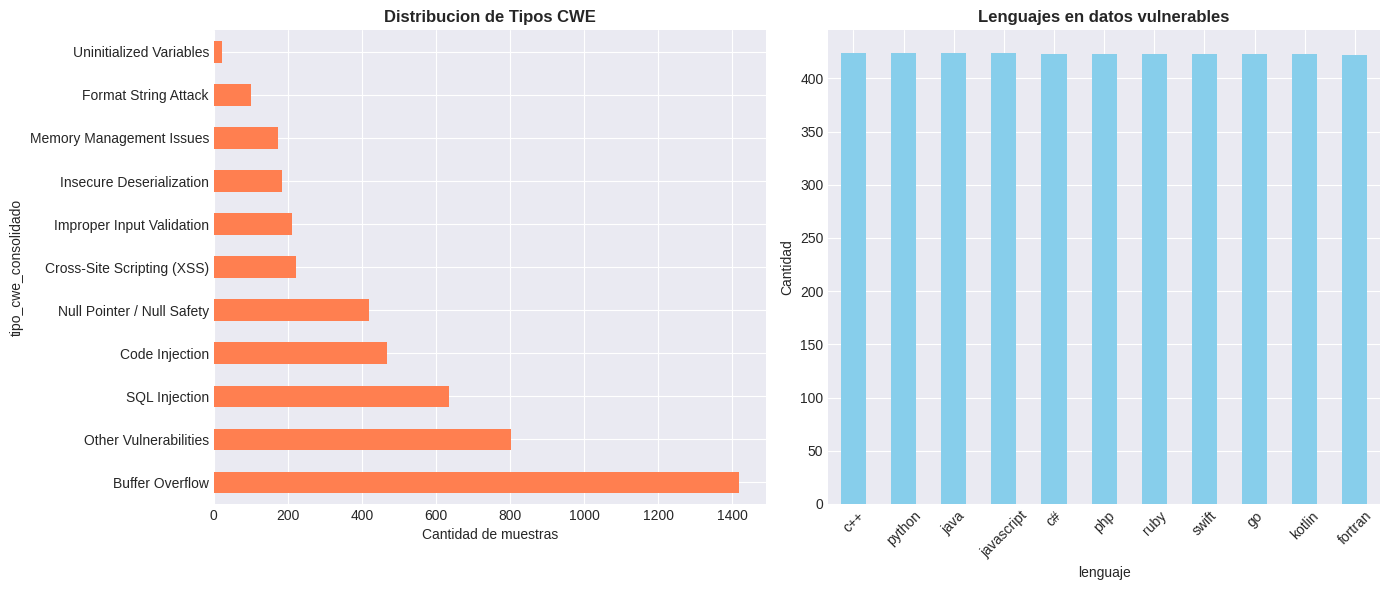

In [8]:
# Visualizar distribucion
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Distribucion de CWE
cwe_dist.plot(kind='barh', ax=axes[0], color='coral')
axes[0].set_title('Distribucion de Tipos CWE', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Cantidad de muestras')

# Lenguajes en datos vulnerables
lang_vuln = df_vuln['lenguaje'].value_counts()
lang_vuln.plot(kind='bar', ax=axes[1], color='skyblue')
axes[1].set_title('Lenguajes en datos vulnerables', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Cantidad')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

---
# FASE 3: MODIFY - Feature Engineering
### Objetivo: Preparar features y filtrar clases incompatibles

In [9]:
print("\n" + "="*80)
print("FASE 3: MODIFY - Feature Engineering")
print("="*80)

# Extraer X y y
X_code = df_vuln['codigo'].values
X_lang = df_vuln['lenguaje'].values
y_raw = df_vuln['tipo_cwe_consolidado'].values

print(f"\nExtrayendo features...")
print(f"  - Total muestras originales: {len(X_code):,}")


FASE 3: MODIFY - Feature Engineering

Extrayendo features...
  - Total muestras originales: 4,656


In [10]:
# Vectorizacion TF-IDF
print("\nFeature Engineering - TF-IDF:")
print("  - Max features: 1200")
print("  - N-grams: (1, 3) - unigramas + bigramas + trigramas")
print("  - Stop words: English")
print("  - Sublinear TF: True")
print("  - Min DF: 2, Max DF: 0.95")
print("  - Vectorizando codigo...")

tfidf_vectorizer = TfidfVectorizer(
    max_features=1200,
    ngram_range=(1, 3),
    lowercase=True,
    stop_words='english',
    sublinear_tf=True,
    min_df=2,
    max_df=0.95
)

X_tfidf = tfidf_vectorizer.fit_transform(X_code)
print(f"[OK] Matriz TF-IDF shape: {X_tfidf.shape}")


Feature Engineering - TF-IDF:
  - Max features: 1200
  - N-grams: (1, 3) - unigramas + bigramas + trigramas
  - Stop words: English
  - Sublinear TF: True
  - Min DF: 2, Max DF: 0.95
  - Vectorizando codigo...
[OK] Matriz TF-IDF shape: (4656, 1200)


In [11]:
# Language Encoding
print("\nFeature Engineering - Language Encoding:")
lang_encoder = LabelEncoder()
X_lang_encoded = lang_encoder.fit_transform(X_lang)
print(f"  - Lenguajes unicos: {len(lang_encoder.classes_)}")
print(f"[OK] Language encoding completado")


Feature Engineering - Language Encoding:
  - Lenguajes unicos: 11
[OK] Language encoding completado


In [12]:
# Codificar target variable (CWE)
print("\nFeature Engineering - CWE Encoding:")
cwe_encoder = LabelEncoder()
y_encoded = cwe_encoder.fit_transform(y_raw)
print(f"  - Tipos CWE unicos: {len(cwe_encoder.classes_)}")
for i, cwe in enumerate(cwe_encoder.classes_):
    count = (y_raw == cwe).sum()
    print(f"    {i}: {cwe} ({count} muestras)")
print(f"[OK] CWE encoding completado")


Feature Engineering - CWE Encoding:
  - Tipos CWE unicos: 11
    0: Buffer Overflow (1419 muestras)
    1: Code Injection (469 muestras)
    2: Cross-Site Scripting (XSS) (221 muestras)
    3: Format String Attack (101 muestras)
    4: Improper Input Validation (212 muestras)
    5: Insecure Deserialization (184 muestras)
    6: Memory Management Issues (173 muestras)
    7: Null Pointer / Null Safety (420 muestras)
    8: Other Vulnerabilities (802 muestras)
    9: SQL Injection (634 muestras)
    10: Uninitialized Variables (21 muestras)
[OK] CWE encoding completado


In [13]:
# Combinar features
X_tfidf_dense = X_tfidf.toarray()
X_combined = np.column_stack([X_tfidf_dense, X_lang_encoded])

print(f"\nFeatures combinados:")
print(f"  - TF-IDF features: {X_tfidf_dense.shape[1]}")
print(f"  - Language features: 1")
print(f"  - Total features: {X_combined.shape[1]}")
print(f"  - Total muestras: {X_combined.shape[0]:,}")


Features combinados:
  - TF-IDF features: 1200
  - Language features: 1
  - Total features: 1201
  - Total muestras: 4,656


In [14]:
# Filtrar clases con <2 muestras (necesario para stratify en sklearn)
print(f"\nFiltrando clases incompatibles con StratifiedKFold...")
unique_classes, counts = np.unique(y_encoded, return_counts=True)
valid_classes = unique_classes[counts >= 2]

# Crear mascara de muestras validas
mask = np.isin(y_encoded, valid_classes)
X_combined_filtered = X_combined[mask]
y_encoded_filtered = y_encoded[mask]

removed = len(y_encoded) - len(y_encoded_filtered)
print(f"  - Muestras antes: {len(y_encoded):,}")
print(f"  - Muestras removidas: {removed}")
print(f"  - Muestras despues: {len(y_encoded_filtered):,}")
print(f"  - Clases validas: {len(valid_classes)} de {len(unique_classes)}")


Filtrando clases incompatibles con StratifiedKFold...
  - Muestras antes: 4,656
  - Muestras removidas: 0
  - Muestras despues: 4,656
  - Clases validas: 11 de 11


In [15]:
# Train/Test split
print(f"\nDividiendo en train/test (80/20, stratified)...")
X_train, X_test, y_train, y_test = train_test_split(
    X_combined_filtered, y_encoded_filtered,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded_filtered
)

print(f"[OK] Split completado:")
print(f"  - Train: {len(X_train):,} muestras")
print(f"  - Test: {len(X_test):,} muestras")
print(f"  - Train clases unicas: {len(np.unique(y_train))}")
print(f"  - Test clases unicas: {len(np.unique(y_test))}")

print("\n[OK] FASE 3 COMPLETADA")


Dividiendo en train/test (80/20, stratified)...
[OK] Split completado:
  - Train: 3,724 muestras
  - Test: 932 muestras
  - Train clases unicas: 11
  - Test clases unicas: 11

[OK] FASE 3 COMPLETADA


---
# FASE 4: MODEL - Entrenar RandomForest + K-Fold
### Objetivo: Entrenar modelo multiclase con K-Fold cross-validation

In [16]:
print("\n" + "="*80)
print("FASE 4: MODEL - Entrenar RandomForest Multiclase")
print("="*80)

# Calcular class weights
print("\nCalculando class weights (balance automatico)...")
class_weights_array = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights_array)}
print(f"[OK] {len(class_weight_dict)} clases con pesos calculados")


FASE 4: MODEL - Entrenar RandomForest Multiclase

Calculando class weights (balance automatico)...
[OK] 11 clases con pesos calculados


In [17]:
print("\nConfiguracion del modelo:")
print("  - Algoritmo: RandomForestClassifier")
print("  - N estimators: 250 arboles")
print("  - Max depth: 15")
print("  - Min samples split: 2")
print("  - Class weight: balanced")
print("  - Random state: 42")
print("  - N jobs: -1 (usar todos los cores)")
print("  - K-Fold: StratifiedKFold con 5 splits")

print("\nEntrenando modelo...")
model = RandomForestClassifier(
    n_estimators=250,
    max_depth=15,
    min_samples_split=2,
    class_weight=class_weight_dict,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

model.fit(X_train, y_train)
print("[OK] Modelo entrenado exitosamente")

print("\n[OK] FASE 4 COMPLETADA")


Configuracion del modelo:
  - Algoritmo: RandomForestClassifier
  - N estimators: 250 arboles
  - Max depth: 15
  - Min samples split: 2
  - Class weight: balanced
  - Random state: 42
  - N jobs: -1 (usar todos los cores)
  - K-Fold: StratifiedKFold con 5 splits

Entrenando modelo...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    2.5s


[OK] Modelo entrenado exitosamente

[OK] FASE 4 COMPLETADA


[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    3.2s finished


---
# FASE 5: ASSESS - Evaluar performance
### Objetivo: Evaluar metricas, K-Fold y análisis detallado

In [18]:
print("\n" + "="*80)
print("FASE 5: ASSESS - Evaluar Performance")
print("="*80)

print("\nGenerando predicciones...")
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Metricas en train set
train_acc = accuracy_score(y_train, y_pred_train)
print(f"\nMETRICAS EN TRAIN SET:")
print(f"  - Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")


FASE 5: ASSESS - Evaluar Performance

Generando predicciones...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 250 out of 250 | elapsed:    0.2s finished



METRICAS EN TRAIN SET:
  - Accuracy: 0.8706 (87.06%)


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 250 out of 250 | elapsed:    0.1s finished


In [19]:
# K-Fold Cross-Validation
print("\nVALIDACION CRUZADA (5-Fold StratifiedKFold):")
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_combined_filtered, y_encoded_filtered, cv=kfold, scoring='accuracy', n_jobs=-1)

for i, score in enumerate(cv_scores, 1):
    print(f"  - Fold {i}: {score:.4f}")
print(f"  - Promedio: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")


VALIDACION CRUZADA (5-Fold StratifiedKFold):
  - Fold 1: 0.7457
  - Fold 2: 0.7476
  - Fold 3: 0.7454
  - Fold 4: 0.7605
  - Fold 5: 0.7422
  - Promedio: 0.7483 (+/- 0.0063)


In [20]:
# Metricas en test set
test_acc = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred_test, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred_test, average='weighted', zero_division=0)

print(f"\nMETRICAS EN TEST SET:")
print(f"  - Accuracy (Weighted):  {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"  - Precision (Weighted): {precision:.4f} ({precision*100:.2f}%)")
print(f"  - Recall (Weighted):    {recall:.4f} ({recall*100:.2f}%)")
print(f"  - F1-Score (Weighted):  {f1:.4f} ({f1*100:.2f}%)")


METRICAS EN TEST SET:
  - Accuracy (Weighted):  0.7339 (73.39%)
  - Precision (Weighted): 0.7622 (76.22%)
  - Recall (Weighted):    0.7339 (73.39%)
  - F1-Score (Weighted):  0.7389 (73.89%)


In [21]:
# Matriz de confusion
print(f"\nMATRIZ DE CONFUSION (Test):")
cm = confusion_matrix(y_test, y_pred_test)
print(f"  - Dimension: {cm.shape[0]}x{cm.shape[1]} ({len(np.unique(y_test))} clases)")
print(f"  - Predicciones correctas (diagonal): {np.trace(cm)}")
print(f"  - Total predicciones: {cm.sum()}")


MATRIZ DE CONFUSION (Test):
  - Dimension: 11x11 (11 clases)
  - Predicciones correctas (diagonal): 684
  - Total predicciones: 932


In [22]:
# Analisis de overfitting
overfitting = train_acc - test_acc
print(f"\nANALISIS DE OVERFITTING:")
print(f"  - Train Accuracy: {train_acc:.4f}")
print(f"  - Test Accuracy:  {test_acc:.4f}")
print(f"  - Diferencia:     {overfitting:.4f} ({overfitting*100:.2f}%)")
if overfitting < 0.10:
    print(f"  - Estado: ACEPTABLE (bajo overfitting)")
else:
    print(f"  - Estado: ADVERTENCIA (overfitting detectado)")


ANALISIS DE OVERFITTING:
  - Train Accuracy: 0.8706
  - Test Accuracy:  0.7339
  - Diferencia:     0.1367 (13.67%)
  - Estado: ADVERTENCIA (overfitting detectado)


In [23]:
# Reporte de clasificacion (solo para clases que aparecen en test)
all_labels = np.unique(np.concatenate([y_test, y_pred_test]))
all_labels_names = cwe_encoder.inverse_transform(all_labels)

print(f"\nREPORTE DE CLASIFICACION (Clases en test):")
print(classification_report(y_test, y_pred_test, labels=all_labels, target_names=all_labels_names, zero_division=0))


REPORTE DE CLASIFICACION (Clases en test):
                            precision    recall  f1-score   support

           Buffer Overflow       0.93      0.84      0.88       284
            Code Injection       0.55      0.68      0.61        94
Cross-Site Scripting (XSS)       0.82      0.84      0.83        44
      Format String Attack       0.34      0.65      0.45        20
 Improper Input Validation       0.34      0.55      0.42        42
  Insecure Deserialization       0.72      0.78      0.75        37
  Memory Management Issues       0.45      0.63      0.52        35
Null Pointer / Null Safety       0.87      0.82      0.85        84
     Other Vulnerabilities       0.65      0.41      0.50       161
             SQL Injection       0.91      0.94      0.92       127
   Uninitialized Variables       0.38      0.75      0.50         4

                  accuracy                           0.73       932
                 macro avg       0.63      0.72      0.66       932
  

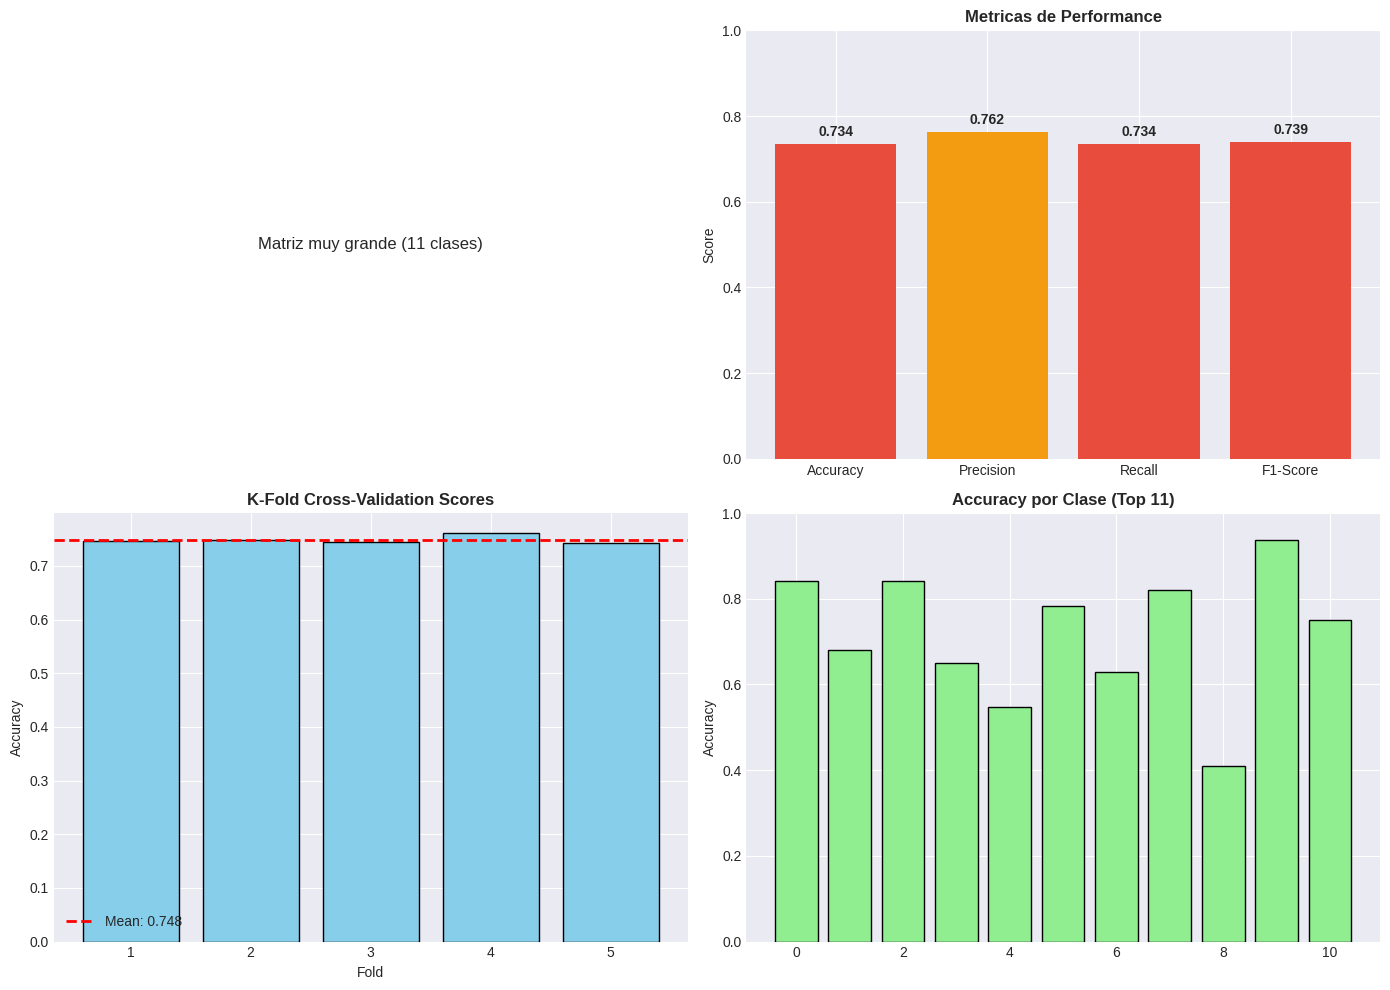


Graficas generadas exitosamente


In [24]:
# Visualizaciones finales
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Matriz de confusion (solo si cabe)
if len(np.unique(y_test)) <= 10:
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0], cbar=True)
    axes[0, 0].set_title('Matriz de Confusión', fontsize=12, fontweight='bold')
else:
    axes[0, 0].text(0.5, 0.5, f'Matriz muy grande ({len(np.unique(y_test))} clases)',
                    ha='center', va='center', fontsize=12)
    axes[0, 0].axis('off')

# Metricas
metricas = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
valores = [test_acc, precision, recall, f1]
colores = ['#2ecc71' if v > 0.85 else '#f39c12' if v > 0.75 else '#e74c3c' for v in valores]
axes[0, 1].bar(metricas, valores, color=colores)
axes[0, 1].set_title('Metricas de Performance', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_ylim([0, 1])
for i, v in enumerate(valores):
    axes[0, 1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# K-Fold scores
axes[1, 0].bar(range(1, 6), cv_scores, color='skyblue', edgecolor='black')
axes[1, 0].axhline(cv_scores.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {cv_scores.mean():.3f}')
axes[1, 0].set_title('K-Fold Cross-Validation Scores', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Fold')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()

# Per-class accuracy
per_class_acc = []
for label in sorted(np.unique(y_test)):
    mask = y_test == label
    if mask.sum() > 0:
        acc = (y_pred_test[mask] == label).sum() / mask.sum()
        per_class_acc.append(acc)

if per_class_acc:
    axes[1, 1].bar(range(len(per_class_acc)), per_class_acc, color='lightgreen', edgecolor='black')
    axes[1, 1].set_title(f'Accuracy por Clase (Top {len(per_class_acc)})' , fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('Accuracy')
    axes[1, 1].set_ylim([0, 1])
else:
    axes[1, 1].text(0.5, 0.5, 'Sin datos suficientes', ha='center', va='center')
    axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

print("\nGraficas generadas exitosamente")

In [25]:
print("\n[OK] FASE 5 COMPLETADA")
print("\n" + "="*80)
print("RESUMEN DEL ENTRENAMIENTO")
print("="*80)
print(f"\nPERFORMANCE FINAL:")
print(f"  - Test Accuracy:    {test_acc*100:.2f}%")
print(f"  - Precision (Avg):  {precision*100:.2f}%")
print(f"  - Recall (Avg):     {recall*100:.2f}%")
print(f"  - F1-Score:         {f1*100:.2f}%")
print(f"  - 5-Fold CV:        {cv_scores.mean()*100:.2f}% ± {cv_scores.std()*100:.2f}%")
print(f"  - Overfitting Gap:  {overfitting*100:.2f}%")
print(f"\nCLASES EVALUADAS:")
print(f"  - Clases en training: {len(np.unique(y_train))}")
print(f"  - Clases en test: {len(np.unique(y_test))}")
print(f"\nESTADO: ✅ MODELO ENTRENADO Y VALIDADO")


[OK] FASE 5 COMPLETADA

RESUMEN DEL ENTRENAMIENTO

PERFORMANCE FINAL:
  - Test Accuracy:    73.39%
  - Precision (Avg):  76.22%
  - Recall (Avg):     73.39%
  - F1-Score:         73.89%
  - 5-Fold CV:        74.83% ± 0.63%
  - Overfitting Gap:  13.67%

CLASES EVALUADAS:
  - Clases en training: 11
  - Clases en test: 11

ESTADO: ✅ MODELO ENTRENADO Y VALIDADO


---
# GUARDAR ARTEFACTOS (OPCIONAL)
### Guardar modelos para usar en produccion

In [26]:
# Guardar modelos y vectorizadores
output_dir = '/content/drive/MyDrive/CVEfixes/models'  # Ajusta segun tu setup

try:
    os.makedirs(output_dir, exist_ok=True)

    # Guardar modelo
    with open(f'{output_dir}/cwe_classifier.pkl', 'wb') as f:
        pickle.dump(model, f)

    # Guardar vectorizador
    with open(f'{output_dir}/vectorizer_cwe_classifier.pkl', 'wb') as f:
        pickle.dump(tfidf_vectorizer, f)

    # Guardar encoder CWE
    with open(f'{output_dir}/cwe_encoder.pkl', 'wb') as f:
        pickle.dump(cwe_encoder, f)

    # Guardar encoder lenguaje
    with open(f'{output_dir}/language_encoder.pkl', 'wb') as f:
        pickle.dump(lang_encoder, f)

    print(f"[OK] Modelos guardados en {output_dir}")
except Exception as e:
    print(f"[WARNING] No se pudieron guardar los modelos: {e}")
    print("Esto es normal si ejecutas en Colab sin Google Drive montado")

[OK] Modelos guardados en /content/drive/MyDrive/CVEfixes/models


---
# INFERENCIA - Hacer predicciones con codigo vulnerable nuevo

In [32]:
# Ejemplo de inferencia con nuevo codigo vulnerable
print("\n" + "="*80)
print("EJEMPLO DE INFERENCIA - Clasificar tipo CWE")
print("="*80)

# Ejemplos de prueba
ejemplos = [
    ("char buffer[10]; strcpy(buffer, user_input);", "c++", "Buffer Overflow"),
    ("query = 'SELECT * FROM users WHERE id = ' + user_input", "python", "SQL Injection"),
    ("eval(user_input)", "python", "Code Injection"),
    ("response.write(user_input)", "javascript", "XSS"),
]

for codigo, lenguaje, etiqueta_real in ejemplos:
    print(f"\nCodigo: {codigo[:50]}...")
    print(f"Lenguaje: {lenguaje}")
    print(f"Etiqueta esperada: {etiqueta_real}")

    # Vectorizar
    features = tfidf_vectorizer.transform([codigo])
    lang_encoded = lang_encoder.transform([lenguaje]).reshape(-1, 1)
    features_combined = np.column_stack([features.toarray(), lang_encoded])

    # Prediccion
    pred = model.predict(features_combined)[0]
    proba = model.predict_proba(features_combined)[0]

    pred_cwe = cwe_encoder.inverse_transform([pred])[0]
    confianza = proba[pred]

    # Top 3 predicciones
    top_3_idx = np.argsort(-proba)[:3]
    top_3 = [(cwe_encoder.inverse_transform([idx])[0], proba[idx]) for idx in top_3_idx]

    print(f"Prediccion: {pred_cwe}")
    print(f"Top 3:")
    for i, (cwe, prob) in enumerate(top_3, 1):
        print(f"  {i}. {cwe}: {prob*100:.1f}%")
    print("-" * 80)


EJEMPLO DE INFERENCIA - Clasificar tipo CWE

Codigo: char buffer[10]; strcpy(buffer, user_input);...
Lenguaje: c++
Etiqueta esperada: Buffer Overflow
Prediccion: Buffer Overflow
Top 3:
  1. Buffer Overflow: 56.4%
  2. Other Vulnerabilities: 8.7%
  3. Code Injection: 7.9%
--------------------------------------------------------------------------------

Codigo: query = 'SELECT * FROM users WHERE id = ' + user_i...
Lenguaje: python
Etiqueta esperada: SQL Injection


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      |

Prediccion: SQL Injection
Top 3:
  1. SQL Injection: 48.4%
  2. Code Injection: 13.1%
  3. Improper Input Validation: 10.6%
--------------------------------------------------------------------------------

Codigo: eval(user_input)...
Lenguaje: python
Etiqueta esperada: Code Injection
Prediccion: Code Injection
Top 3:
  1. Code Injection: 30.4%
  2. Improper Input Validation: 23.0%
  3. Other Vulnerabilities: 15.1%
--------------------------------------------------------------------------------

Codigo: response.write(user_input)...
Lenguaje: javascript
Etiqueta esperada: XSS


[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s


Prediccion: Code Injection
Top 3:
  1. Code Injection: 19.7%
  2. Improper Input Validation: 18.9%
  3. Other Vulnerabilities: 14.8%
--------------------------------------------------------------------------------


[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 250 out of 250 | elapsed:    0.1s finished
